In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Ensure plots display inline in the notebook
%matplotlib inline

# Set a visual style
sns.set_style("whitegrid")

In [2]:
# Load Data
try:
    df = pd.read_csv("cs-training.csv", index_col=0)
    print("Shape:", df.shape)
    print("\nTarget Distribution:")
    print(df["SeriousDlqin2yrs"].value_counts())
except FileNotFoundError:
    print("Error: 'cs-training.csv' not found. Please ensure the file is in the same directory.")

Shape: (150000, 11)

Target Distribution:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64


In [3]:
# Drop rows with missing values in specific columns
df.dropna(subset=["MonthlyIncome", "NumberOfDependents"], inplace=True)

# Cap outliers at the 99th percentile
cols_to_cap = ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome"]
for col in cols_to_cap:
    cap = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=cap)

# Filter invalid ages
df = df[df["age"] >= 18]

print("Shape after cleaning:", df.shape)

Shape after cleaning: (120268, 11)


In [4]:
# 1. Aggregated Late Payments
df["TotalLate"] = (
    df["NumberOfTime30-59DaysPastDueNotWorse"] +
    df["NumberOfTime60-89DaysPastDueNotWorse"] +
    df["NumberOfTimes90DaysLate"]
)

# 2. Weighted Delinquency Score
df["DelinquencyScore"] = (
    df["NumberOfTime30-59DaysPastDueNotWorse"] * 1 +
    df["NumberOfTime60-89DaysPastDueNotWorse"] * 2 +
    df["NumberOfTimes90DaysLate"]              * 3
)

# 3. Financial Ratios
df["DebtToIncome"]       = df["DebtRatio"] / (df["MonthlyIncome"] + 1)
df["IncomePerDependent"] = df["MonthlyIncome"] / (df["NumberOfDependents"] + 1)

print("Feature engineering complete.")

Feature engineering complete.


In [5]:
# Define Features (X) and Target (y)
X = df.drop(columns=["SeriousDlqin2yrs"])
y = df["SeriousDlqin2yrs"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Apply SMOTE to Training Data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original Training counts:", y_train.value_counts().to_dict())
print("Resampled Training counts:", y_train_res.value_counts().to_dict())

Original Training counts: {0: 83933, 1: 6268}
Resampled Training counts: {0: 83933, 1: 83933}


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

In [7]:
print("Training models... this may take a minute.")

# 1. Logistic Regression
lr = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_res)

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_leaf=5, random_state=42)
rf.fit(X_train_res, y_train_res)

# 3. XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
    reg_lambda=2.0, random_state=42, verbosity=0, eval_metric="logloss"
)
xgb.fit(X_train_res.values, y_train_res)

# 4. KNN
knn = KNeighborsClassifier(n_neighbors=15, weights="distance")
knn.fit(X_train_scaled, y_train_res)

print("All models trained successfully.")

Training models... this may take a minute.
All models trained successfully.


In [8]:
models = {
    "Logistic Regression": (lr,  X_test_scaled),
    "Random Forest":       (rf,  X_test),
    "XGBoost":             (xgb, X_test.values),
    "KNN":                 (knn, X_test_scaled),
}

print("\n{:<25} {}".format("Model", "AUC Score"))
print("-" * 35)
for name, (model, X_eval) in models.items():
    auc = roc_auc_score(y_test, model.predict_proba(X_eval)[:, 1])
    print("{:<25} {:.3f}".format(name, auc))


Model                     AUC Score
-----------------------------------
Logistic Regression       0.788
Random Forest             0.838
XGBoost                   0.822
KNN                       0.756


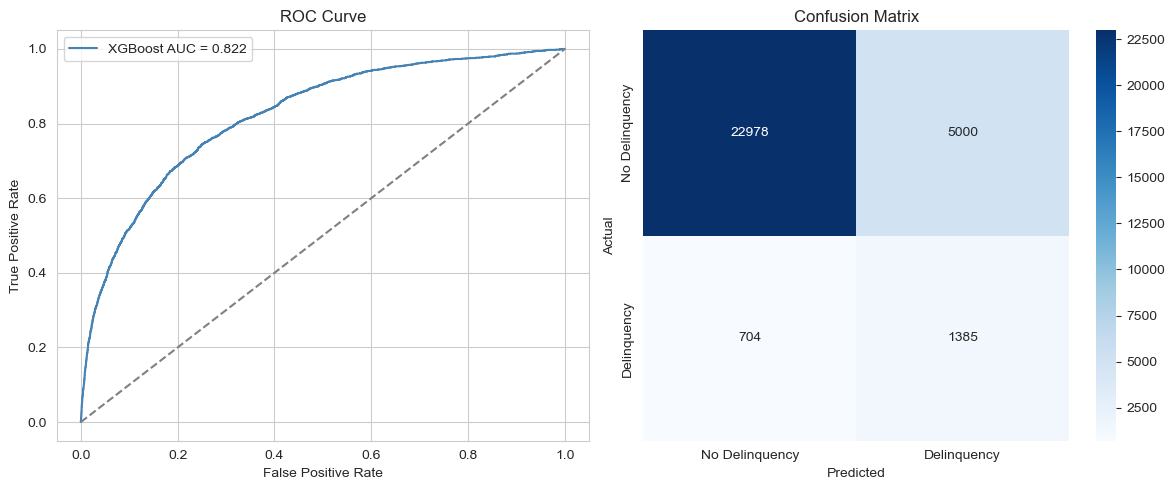

Classification Report:

                precision    recall  f1-score   support

No Delinquency       0.97      0.82      0.89     27978
   Delinquency       0.22      0.66      0.33      2089

      accuracy                           0.81     30067
     macro avg       0.59      0.74      0.61     30067
  weighted avg       0.92      0.81      0.85     30067



In [9]:
# --- ROC Curve ---
y_prob = xgb.predict_proba(X_test.values)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color="steelblue", label=f"XGBoost AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# --- Confusion Matrix ---
y_pred = xgb.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Delinquency", "Delinquency"],
            yticklabels=["No Delinquency", "Delinquency"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Delinquency", "Delinquency"]))

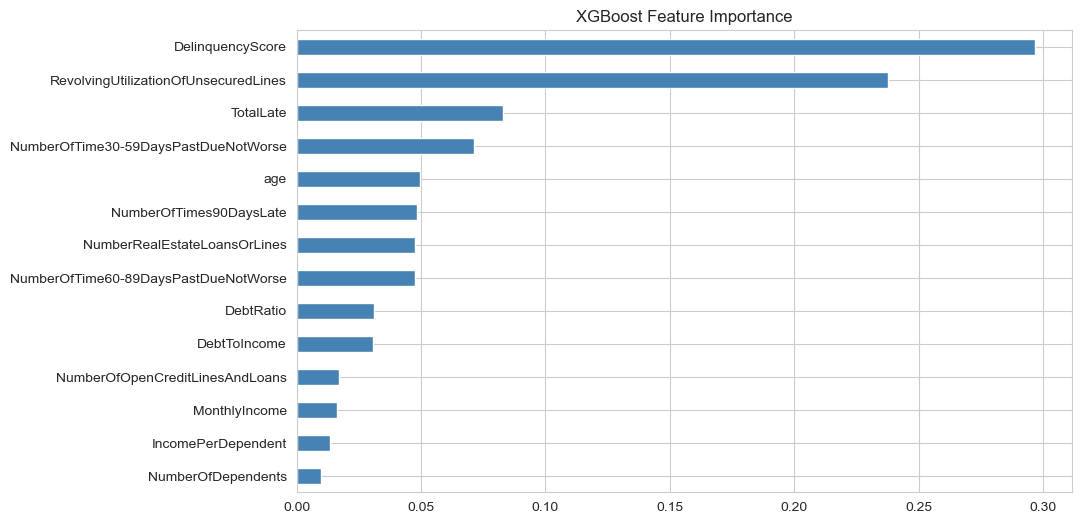

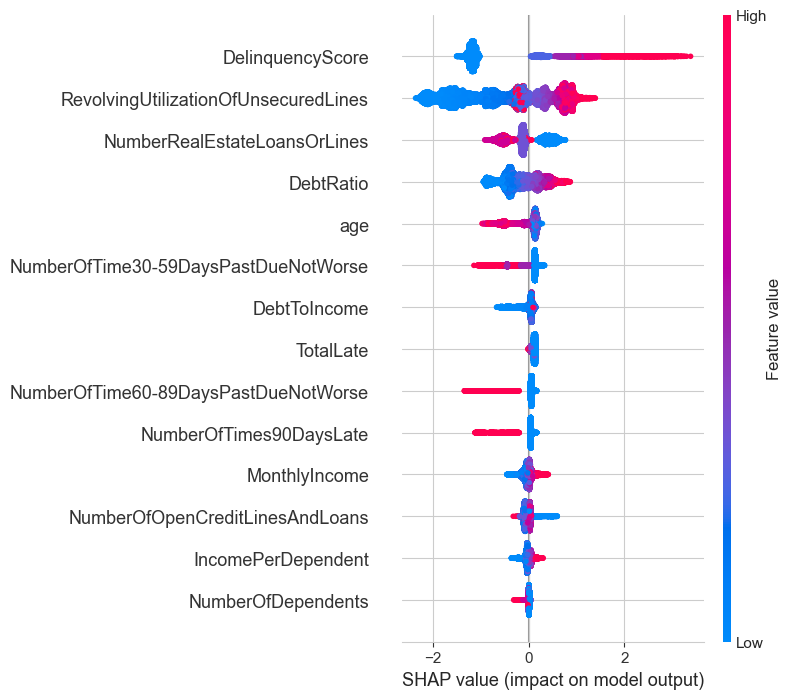

In [10]:
# --- Feature Importance ---
importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importance.plot(kind="barh", color="steelblue")
plt.title("XGBoost Feature Importance")
plt.show()

# --- SHAP Values ---
# Note: SHAP calculations can be computationally expensive
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.values)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test.values, feature_names=X.columns.tolist(), show=True)

In [11]:
# 1. Save Model
joblib.dump(xgb, "model.pkl")
print("Model saved as 'model.pkl'")

# 2. Load and Process Test Data
try:
    df_test = pd.read_csv("cs-test.csv", index_col=0)
    
    # Feature Engineering (Must match training exactly)
    df_test["TotalLate"] = (
        df_test["NumberOfTime30-59DaysPastDueNotWorse"] +
        df_test["NumberOfTime60-89DaysPastDueNotWorse"] +
        df_test["NumberOfTimes90DaysLate"]
    )
    df_test["DelinquencyScore"] = (
        df_test["NumberOfTime30-59DaysPastDueNotWorse"] * 1 +
        df_test["NumberOfTime60-89DaysPastDueNotWorse"] * 2 +
        df_test["NumberOfTimes90DaysLate"]              * 3
    )
    df_test["DebtToIncome"]       = df_test["DebtRatio"] / (df_test["MonthlyIncome"] + 1)
    df_test["IncomePerDependent"] = df_test["MonthlyIncome"] / (df_test["NumberOfDependents"] + 1)

    # Caps (using training data quantiles where available, otherwise just applying logic)
    # Note: Ideally, we use exact values from the training step. 
    # Here we re-calculate quantiles from df (training data) which is still in memory.
    for col in ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome"]:
        if col in df_test.columns:
            df_test[col] = df_test[col].clip(upper=df[col].quantile(0.99))

    # Imputation
    df_test["MonthlyIncome"] = df_test["MonthlyIncome"].fillna(df_test["MonthlyIncome"].median())
    df_test["NumberOfDependents"] = df_test["NumberOfDependents"].fillna(0)

    # Align columns
    df_test = df_test.drop(columns=["SeriousDlqin2yrs"], errors="ignore")
    df_test = df_test[X.columns] # Ensure strict column order match

    # Predict
    submission = pd.DataFrame({
        "Id": df_test.index,
        "Probability": xgb.predict_proba(df_test.values)[:, 1]
    })
    
    submission.to_csv("sampleEntry.csv", index=False)
    print("Submission saved as 'sampleEntry.csv'")

except FileNotFoundError:
    print("Error: 'cs-test.csv' not found. Skipping submission generation.")

Model saved as 'model.pkl'
Error: 'cs-test.csv' not found. Skipping submission generation.
